# Network IOP and Acceleration

The Network IO Processor (IOP) enables raw access to the Ethernet interface from within Python.
The usage is similar in many ways to sending and receiving Ethernet frames using raw sockets.

The advantages of this access include:
1. Packets can be sent with low-latency, bypassing the normal Linux kernel stack.
2. Access to the network interface is memory-mapped, enabling network-connected accelerators
   to be prototyped on the ARM cores and then migrated into the Programmable Logic (PL).

In software, the code typically executes with about 10ms between publish events.
When accelerated using the PL, the code executes about 120us between publish events.

The following is a table of the memory mapped registers:

|         AXILiteS           ||
|:-----------|:----------------|
| 0x00 | Control signals                                        |
|      |  bit 0  - ap_start (Read/Write/COH)                    |
|      |  bit 1  - ap_done (Read/COR)                           |
|      |  bit 2  - ap_idle (Read)                               |
|      |  bit 3  - ap_ready (Read)                              |
|      |  bit 7  - auto_restart (Read/Write)                    |
|      |  others - reserved                                     |
| 0x04 | Global Interrupt Enable Register                       |
|      |  bit 0  - Global Interrupt Enable (Read/Write)         |
|      |  others - reserved                                     |
| 0x08 | IP Interrupt Enable Register (Read/Write)              |
|      |  bit 0  - Channel 0 (ap_done)                          |
|      |  bit 1  - Channel 1 (ap_ready)                         |
|      |  others - reserved                                     |
| 0x0c | IP Interrupt Status Register (Read/TOW)                |
|      |  bit 0  - Channel 0 (ap_done)                          |
|      |  bit 1  - Channel 1 (ap_ready)                         |
|      |  others - reserved                                     |
| 0x10 | Data signal of b                                       |
|      |  bit 0  - b[0] (Read/Write)                            |
|      |  others - reserved                                     |
| 0x14 | reserved                                               |
| 0x18 | Data signal of macAddress_V                            |
|      |  bit 31~0 - macAddress_V[31:0] (Read/Write)            |
| 0x1c | Data signal of macAddress_V                            |
|      |  bit 15~0 - macAddress_V[47:32] (Read/Write)           |
|      |  others   - reserved                                   |
| 0x20 | reserved                                               |
| 0x24 | Data signal of ipAddress_V                             |
|      |  bit 31~0 - ipAddress_V[31:0] (Read/Write)             |
| 0x28 | reserved                                               |
| 0x2c | Data signal of i                                       |
|      |  bit 31~0 - i[31:0] (Read/Write)                       |
| 0x30 | reserved                                               |
| 0x34 | Data signal of destIP_V                                |
|      |  bit 31~0 - destIP_V[31:0] (Read/Write)                |
| 0x38 | reserved                                               |
| 0x3c | Data signal of destPort                                |
|      |  bit 31~0 - destPort[31:0] (Read/Write)                |
| 0x40 | reserved                                               |
| 0x44 | Data signal of topicID_V                               |
|      |  bit 15~0 - topicID_V[15:0] (Read/Write)               |
|      |  others   - reserved                                   |
| 0x48 | reserved                                               |
| 0x4c | Data signal of qos                                     |
|      |  bit 31~0 - qos[31:0] (Read/Write)                     |
| 0x50 | reserved                                               |
| 0x54 | Data signal of message                                 |
|      |  bit 31~0 - message[31:0] (Read/Write)                 |
| 0x58 | reserved                                               |
| 0x5c | Data signal of validMessage                            |
|      |  bit 0  - validMessage[0] (Read/Write)                 |
|      |  others - reserved                                     |
| 0x60 | reserved                                               |
| 0x64 | Data signal of network IOP offset                       |
|      |  bit 31~0 - network IOP offset[31:0] (Read/Write)       |
| 0x68 | reserved                                               |
| 0x6c | Data signal of count                                   |
|      |  bit 31~0 - count[31:0] (Read/Write)                   |
| 0x70 | reserved                                               |
| 0x74 | Data signal of size                                    |
|      |  bit 31~0 - size[31:0] (Read/Write)                    |
| 0x78 | reserved                                               |
| 0x7c | Data signal of reset                                   |
|      |  bit 0  - reset[0] (Read/Write)                        |
|      |  others - reserved                                     |
| 0x80 | reserved                                               |
| 0x84 | Data signal of p_verbose                               |
|      |  bit 0  - p_verbose[0] (Read/Write)                    |
|      |  others - reserved                                     |
| 0x88 | reserved                                               |
| 0x8c | Data signal of events_completed                        |
|      |  bit 31~0 - events_completed[31:0] (Read)              |
| 0x90 | Control signal of events_completed                     |
|      |  bit 0  - events_completed_ap_vld (Read/COR)           |
|      |  others - reserved                                     |
| 0x94 | Data signal of publishes_sent                          |
|      |  bit 31~0 - publishes_sent[31:0] (Read)                |
| 0x98 | Control signal of publishes_sent                       |
|      |  bit 0  - publishes_sent_ap_vld (Read/COR)             |
|      |  others - reserved                                     |
| 0x9c | Data signal of packets_received                        |
|      |  bit 31~0 - packets_received[31:0] (Read)              |
| 0xa0 | Control signal of packets_received                     |
|      |  bit 0  - packets_received_ap_vld (Read/COR)           |
|      |  others - reserved                                     |
| 0xa4 | Data signal of packets_sent                            |
|      |  bit 31~0 - packets_sent[31:0] (Read)                  |
| 0xa8 | Control signal of packets_sent                         |
|      |  bit 0  - packets_sent_ap_vld (Read/COR)               |
|      |  others - reserved                                     |


*SC = Self Clear, COR = Clear on Read, TOW = Toggle on Write, COH = Clear on Handshake*

## 1. Downloading overlay
Now let's download the overlay and do necessary configurations.

In [1]:
from pynq_networking import MqttsnOverlay

mqttsn_bit = "/opt/python3.6/lib/python3.6/site-packages/" + \
             "pynq_networking/overlays/mqttsn/mqttsn.bit"
overlay = MqttsnOverlay(mqttsn_bit)
overlay.download()

In [2]:
import timeit
import logging
logging.getLogger("scapy.runtime").setLevel(logging.ERROR)
from scapy.all import *
from wurlitzer import sys_pipes
from pynq_networking.lib.network_iop import NetworkIOP
from pynq_networking.lib.slurper import PacketSlurper
from pynq_networking.lib.pynqsocket import L2PynqSocket

conf.L2PynqSocket = L2PynqSocket

## 2. Read the temperature sensor value
Now let's read the temperature values from Pmod TMP2. In this example,
Pmod TMP2 has to be plugged into the PMODB interface on PYNQ-Z1.

In [3]:
from pynq.lib.pmod import Pmod_TMP2
from pynq_networking.lib.accelerator import Accelerator

pmod_tmp2 = Pmod_TMP2(overlay.PMODB)
pkt_accel = Accelerator()

print("Reading TMP2 from MicroBlaze: {}".format(pmod_tmp2.read()))

with sys_pipes():
    print("Reading TMP2 from SDSoC: {}".format(
        pkt_accel.read_sensor(pmod_tmp2.microblaze)))

Reading TMP2 from MicroBlaze: 30.4
Reading TMP2 from SDSoC: 30.375


## 3. Bring up interfaces and modules
We can bring up a network interface for testing. 
For hardware acceleration, we need to inject the Linux kernel driver.

The Python class `LinkManager` is a wrapper for the following commands:
```csh
chmod 777 ./kernel_module/*.sh
ifconfig br0:1 192.168.3.99
ifconfig br0:0 192.168.1.99
./kernel_module/link_up.sh
```

In [4]:
from pynq_networking import LinkManager

if_manager = LinkManager()
if_manager.if_up("br0:1", "192.168.3.99")
if_manager.if_up("br0:0", "192.168.1.99")
if_manager.kernel_up()

The kernel module only needs to be brought up 1 time after the 
board has been booted.

## 4. Setup broker
We will use the IP associated with `br0:1` to set up the broker.
For the network IOP, the packets have to be flushed first.

In [5]:
from pynq_networking import Broker
from pynq_networking import get_ip_string, get_mac_string
from pynq_networking.lib.network_iop import NetworkIOP
from pynq_networking.lib.mqttsn_hw import MQTT_Client_PL

serverIP = "192.168.3.99"
serverPort = 1884

broker_mqtt = Broker(ip_address=serverIP, mqttsn_port=serverPort)
broker_mqtt.open()

In [6]:
mynet = NetworkIOP()
mytmp = pmod_tmp2.microblaze

conf.L2PynqSocket().flush()

8 packets flushed


## 5. Publish events with accelerator
We will now use the hardware accelerator to publish events. 
The Python API is shown below:
```Python
    def publish_mmio(self, size, count, pl_mac_address, pl_ip_address,
                     server_ip_address, server_port_number,
                     topic_id, qos, verbose, net_iop, sensor_iop):
        """Publish data from the given temperature sensor to an MQTTSN server.

        This method will use the MMIO to control the accelerator.

        Parameters
        ----------
        size : int
            The size of frames to generate.
        count : int
            The number of publish events to complete.
        pl_mac_address : int/str
            The MAC Address of the PL accelerator (not the host MAC address).
        pl_ip_address : int/str
            The IP Address of the PL accelerator (not the host IP address).
        server_ip_address : int/str
            The IP Address of the MQTTSN server.
        server_port_number : int
            The port number of the MQTTSN server.
        topic_id : int
            The topic ID to publish on.
        qos : int
            The MQTTSN qos to use (0 means response is not required).
        verbose : int
            A non-zero value will get verbose debugging information.
        net_iop : NetworkIOP
            The network IOP object.
        sensor_iop : Pmod_TMP2
            The temperature sensor object.

        """
```


For example, we can call:
```python
from broker_client.accelerator import Accelerator

pkt_accel = Accelerator()
pkt_accel.publish_mmio(100, 5, local_mac, local_ip, 
                       serverIP, serverPort, 
                       1, 0, 1, mynet, mytmp)
```

We can keep publishing events and see how fast we can publish them.
The following cell is using a thin wrapper for the MQTT client. Internally,
it calls the `Accelerator()` class and uses `publish_mmio()` method.

Users can also check the frame content using:

```python
frame = conf.L2PynqSocket().recv()
print(frame)
```

In [7]:
conf.L2PynqSocket().flush()
count = 500
with sys_pipes():
    with MQTT_Client_PL(serverIP, serverPort, "client-hw") as client:
        topicID = client.register("temperature")
        client.publish_sw(topicID, "27.0")
        conf.L2PynqSocket().flush()

        start_time = timeit.default_timer()
        client.publish_hw(mynet, mytmp, topicID, 0, range(count))
        elapsed = timeit.default_timer() - start_time

print("HW publish speed: " + str(count/elapsed)+" packets/second.")

5 packets flushed
MQTTSN: Ether / IP / UDP 192.168.3.99:1884 > 192.168.1.104:50000 / MQTTSN / MQTTSN_CONNACK / Padding
MQTTSN: Ether / IP / UDP 192.168.3.99:1884 > 192.168.1.104:50000 / MQTTSN / MQTTSN_REGACK / Padding
MQTTSN: Ether / IP / UDP 192.168.3.99:1884 > 192.168.1.104:50000 / MQTTSN / MQTTSN_PUBACK / Padding
1 packets flushed
calls 998
events_completed: 500
PublishesSent: 500
PacketsReceived: 3
PacketsSent: 500
HW publish speed: 3603.894590521659 packets/second.


In [8]:
conf.L2PynqSocket().flush()
count = 500
with sys_pipes():
    with MQTT_Client_PL(serverIP, serverPort, "client-sw") as client:
        temp_topicID = client.register("temperature")
        client.publish_sw(topicID, "27.0")
        conf.L2PynqSocket().flush()

        start_time = timeit.default_timer()  
        temperature = str(pmod_tmp2.read())
        for i in range(count):
            client.publish_sw(temp_topicID, temperature, qos=0)
        elapsed = timeit.default_timer() - start_time

print("SW publish speed: " + str(count/elapsed)+" packets/second.")

19 packets flushed
MQTTSN: Ether / IP / UDP 192.168.3.99:1884 > 192.168.1.104:50000 / MQTTSN / MQTTSN_CONNACK / Padding
MQTTSN: Ether / IP / UDP 192.168.3.99:1884 > 192.168.1.104:50000 / MQTTSN / MQTTSN_REGACK / Padding
MQTTSN: Ether / IP / UDP 192.168.3.99:1884 > 192.168.1.104:50000 / MQTTSN / MQTTSN_PUBACK / Padding
7 packets flushed
SW publish speed: 47.155923260752544 packets/second.


## 6. Performance breakdown
We can do a bit research here. Let's find out how fast we can push out 
packets first, as shown below.

In [9]:
import numpy as np
import matplotlib.pyplot as plt
from pynq import PL
from pynq import MMIO
from pynq_networking import *

sizes = [64, 128, 256, 512, 1024, 1500]
count = 500
pps = []
bps = []
usperpacket = []
cyclesperword = []
theoretical = []
mmio = MMIO(0xFFFC0000, 0x10000)

my_ip_str = '192.168.1.104'
my_mac_str = '8a:70:bd:29:2b:40'

for size in sizes:
    payload = b''.join([b'0' for _ in range(size)])
    frame = Ether(src=my_mac_str, dst='FF:FF:FF:FF:FF:FF')/\
        IP(src=my_ip_str, dst="192.168.1.2")/\
        UDP(sport=50000, dport=1884)/MQTTSN()/MQTTSN_CONNECT()
    frame = bytes(frame) + payload
    slurper = conf.L2PynqSocket().slurper
    scapySocket = conf.L2socket()
    write32 = slurper.write32
    array = slurper.mmio.array
    mem = slurper.mmio.mem
    leng = len(frame)

    start_time = timeit.default_timer()
    for _ in range(count):
        frame_bytes = bytes(frame)
        slurper.send(frame_bytes)
    elapsed = timeit.default_timer() - start_time

    bps.append(count*len(frame)*8/elapsed)
    pps.append(count/elapsed)
    usperpacket.append(1000000/(count/elapsed))
    cyclesperword.append((100000000*elapsed)/(count*(len(frame)/4)))
    theoretical.append(100000000/(len(frame)/4))

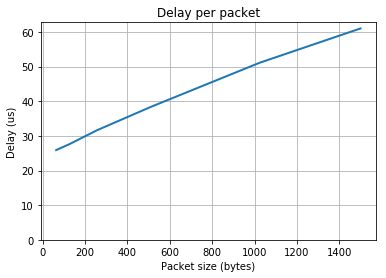

In [10]:
plt.title("Delay per packet")
plt.plot(sizes, usperpacket, linewidth=2.0)
plt.ylim(ymin=0)
plt.xlabel('Packet size (bytes)')
plt.ylabel('Delay (us)')
plt.grid(True)
plt.show()

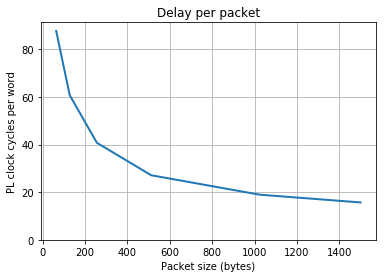

In [11]:
plt.title("Delay per packet")
plt.plot(sizes, cyclesperword, linewidth=2.0)
plt.ylim(ymin=0)
plt.xlabel('Packet size (bytes)')
plt.ylabel('PL clock cycles per word')
plt.grid(True)
plt.show()

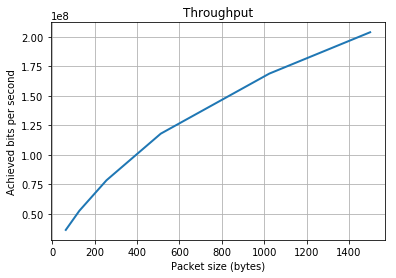

In [12]:
plt.title("Throughput")
plt.plot(sizes, bps, linewidth=2.0)
plt.xlabel('Packet size (bytes)')
plt.ylabel('Achieved bits per second')
plt.grid(True)
plt.show()

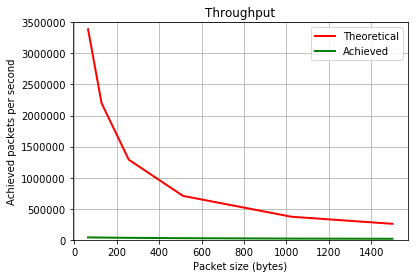

In [13]:
plt.title("Throughput")
plot0, = plt.plot(sizes, theoretical, label='Theoretical',
                  linewidth=2.0, color='red')
plot1, = plt.plot(sizes, pps, label='Achieved', 
                  linewidth=2.0, color='green')
plt.legend(handles=[plot0, plot1])
plt.ylim(ymin=0, ymax=3500000)
plt.xlabel('Packet size (bytes)')
plt.ylabel('Achieved packets per second')
plt.grid(True)
plt.show()

Next we can test how fast we can read the temperature sensor.

In [14]:
count = 1000

start_time = timeit.default_timer()
for _ in range(count):
    x = pmod_tmp2.read()
elapsed = timeit.default_timer() - start_time

print("Sensor performs " + str(count/elapsed)+" reads/second.")
print("Temperature is " + str(x) + " degrees.")

Sensor performs 1229.2402843072214 reads/second.
Temperature is 30.4 degrees.


## 7. Cleanup
We can remove the kernel module and close the broker in the end.

In [15]:
if_manager.kernel_down()
if_manager.if_down('br0:0')
if_manager.if_down('br0:1')
broker_mqtt.close()